<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/UnetSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!rm -rf *

Tue Oct 20 04:19:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ERgktnjHms9DroR01IFSAsEBGQipq3SG8sjTZUSEQuRK9Q?download=1"
!mv "ERgktnjHms9DroR01IFSAsEBGQipq3SG8sjTZUSEQuRK9Q?download=1" "DRIVE.rar"
!unrar x DRIVE.rar
!rm "DRIVE.rar"

--2020-10-20 04:19:52--  https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ERgktnjHms9DroR01IFSAsEBGQipq3SG8sjTZUSEQuRK9Q?download=1
Resolving correoipn-my.sharepoint.com (correoipn-my.sharepoint.com)... 13.107.136.9
Connecting to correoipn-my.sharepoint.com (correoipn-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/ccarrillog1400_alumno_ipn_mx/Documents/Data%20Bases/Other%20Databases/DRIVE.rar?originalPath=aHR0cHM6Ly9jb3JyZW9pcG4tbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvY2NhcnJpbGxvZzE0MDBfYWx1bW5vX2lwbl9teC9FUmdrdG5qSG1zOURyb1IwMUlGU0FzRUJHUWlwcTNTRzhzalRaVVNFUXVSSzlRP3J0aW1lPThHRjVaSzkwMkVn [following]
--2020-10-20 04:19:52--  https://correoipn-my.sharepoint.com/personal/ccarrillog1400_alumno_ipn_mx/Documents/Data%20Bases/Other%20Databases/DRIVE.rar?originalPath=aHR0cHM6Ly9jb3JyZW9pcG4tbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvY2NhcnJpbGxvZzE0MDBfYWx1bW5vX2lwbl9teC9FUmdrdG5qSG

In [3]:
!git clone --depth 1 https://github.com/Vengadore/Segmentation_OPTOS.git

Cloning into 'Segmentation_OPTOS'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 0), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import os

## Load Data

In [5]:
path = "./"
os.listdir(path)

['.config',
 'training',
 'test',
 'training.csv',
 'Segmentation_OPTOS',
 'test_1stmanual.csv',
 'test_2ndmanual.csv']

In [6]:
data = pd.read_csv(os.path.join(path,'training.csv'))
data_test = pd.read_csv(os.path.join(path,'test_1stmanual.csv'))
data.head()

,Original,GroundTruth
0,21_training.tif,21_manual1.tif
1,22_training.tif,22_manual1.tif
2,23_training.tif,23_manual1.tif
3,24_training.tif,24_manual1.tif
4,25_training.tif,25_manual1.tif


In [7]:
data['Original'] = data['Original'].apply(lambda x:os.path.join(path,"training/images/"+x))
data['GroundTruth'] = data['GroundTruth'].apply(lambda x:os.path.join(path,"training/1st_manual/"+x))
data.head()

,Original,GroundTruth
0,./training/images/21_training.tif,./training/1st_manual/21_manual1.tif
1,./training/images/22_training.tif,./training/1st_manual/22_manual1.tif
2,./training/images/23_training.tif,./training/1st_manual/23_manual1.tif
3,./training/images/24_training.tif,./training/1st_manual/24_manual1.tif
4,./training/images/25_training.tif,./training/1st_manual/25_manual1.tif


In [8]:
data_test['Original'] = data_test['Original'].apply(lambda x:os.path.join(path,"test/images/"+x))
data_test['GroundTruth'] = data_test['GroundTruth'].apply(lambda x:os.path.join(path,"test/1st_manual/"+x))
data.head()

,Original,GroundTruth
0,./training/images/21_training.tif,./training/1st_manual/21_manual1.tif
1,./training/images/22_training.tif,./training/1st_manual/22_manual1.tif
2,./training/images/23_training.tif,./training/1st_manual/23_manual1.tif
3,./training/images/24_training.tif,./training/1st_manual/24_manual1.tif
4,./training/images/25_training.tif,./training/1st_manual/25_manual1.tif


In [10]:
## Resize training images
import os
import cv2
for i in data['Original']:
  I = cv2.imread(i)
  I = cv2.resize(I,(584*3, 565*3),cv2.INTER_CUBIC)
  I = cv2.imwrite(i,I)

In [15]:
for i in data['GroundTruth']:
  I = cv2.imread(i)
  I = cv2.resize(I,(584*3, 565*3),cv2.INTER_CUBIC)
  I = cv2.imwrite(i,I)

In [16]:
for i in data_test['Original']:
  I = cv2.imread(i)
  I = cv2.resize(I,(584*3, 565*3),cv2.INTER_CUBIC)
  I = cv2.imwrite(i,I)
for i in data_test['GroundTruth']:
  I = cv2.imread(i)
  I = cv2.resize(I,(584*3, 565*3),cv2.INTER_CUBIC)
  I = cv2.imwrite(i,I)

## Creation of dataloader

In [17]:
from Segmentation_OPTOS.Tools.Generators import Patch_generator
import cv2

In [18]:
def x_trans(X):
    #X = cv2.resize(X,(584*2, 565*2),cv2.INTER_CUBIC)
    #mean,std = cv2.meanStdDev(X)
    #_,_,C = X.shape
    #for i in range(C):
    #    X[:,:,i] = (X[:,:,i]-mean[i])/std[i]
    ## Change order of channels
    X = X.transpose(2,0,1)
    return X

def y_trans(X):
    # Change order of channels
    #X = cv2.resize(X,(584*3, 565*3),cv2.INTER_CUBIC)
    X = X.transpose(2,0,1)
    X = np.expand_dims(X[0,:,:],axis = 0)
    return X

Training_patches = Patch_generator.Generator_from_DataFrame(data,patch_size=(63,63),X = 'Original',
                                                   y = "GroundTruth",n_patches = 80,transforX=x_trans,transfory=y_trans)

Validation_patches = Patch_generator.Generator_from_DataFrame(data,patch_size=(63,63),X = 'Original',
                                                   y = "GroundTruth",n_patches = 80,transforX=x_trans,transfory=y_trans)

20 files found out of 20 in the DataFrame for X
20 files found out of 20 in the DataFrame for y
A generator object has been created with 80 per image
20 files found out of 20 in the DataFrame for X
20 files found out of 20 in the DataFrame for y
A generator object has been created with 80 per image


## Definition of the network

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = nn.Conv2d(3,256,(3,3),stride = (1,1),padding=(1,1))
        self.norm1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256,128,(3,3),stride = (1,1),padding=(1,1))
        self.norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,64,(3,3),stride = (1,1),padding=(1,1))
        self.norm3 = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d((2,2))
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.norm1(x)
        x = F.relu(self.conv2(x))
        x = self.norm2(x)
        x = F.relu(self.conv3(x))
        x = self.norm3(x)
        x = self.max_pool(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1T = nn.ConvTranspose2d(64,64,(3,3),padding=(1,1))
        self.conv2T = nn.ConvTranspose2d(64,64,(3,3),stride=(2,2),padding=(1,1))
        self.conv3T = nn.ConvTranspose2d(64,128,(3,3),padding=(1,1))
        self.conv4T = nn.ConvTranspose2d(128,256,(3,3))
        self.conv5T = nn.ConvTranspose2d(256,1,(1,1))
    def forward(self,x):
        x = F.relu(self.conv1T(x))
        x = F.relu(self.conv2T(x))
        x = F.relu(self.conv3T(x))
        x = F.relu(self.conv4T(x))
        x = torch.sigmoid(self.conv5T(x))
        return x
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self,x):
        x = self.encoder.forward(x)
        x = self.decoder.forward(x)
        return x

In [21]:
model = Model()

In [22]:
# Load Pretrained Model
model = torch.load("./Modelo_seg.ph")

In [23]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [24]:
model = model.to(device)

In [25]:
63*63*80*len(data)

6350400

## Train Network

In [31]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(50000):  # loop over the dataset multiple times
    running_loss = 0.0
    ## Training loop for epoch
    Accuracy = 0.0
    for i in range(len(data)):
        (X,y) = next(Training_patches)
        X = torch.FloatTensor(X).to(device)
        y = torch.Tensor(y).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        # Accuracy
        #Accuracy += np.sum(np.max(y.detach().cpu().numpy()) == np.max(outputs.detach().cpu().numpy()))
        # print statistics
        running_loss += loss.item()
    print(f"Epoch:{epoch+1} Loss:{running_loss} ")#Accuracy = {Accuracy/6350400}")

print('Finished Training')

Epoch:1 Loss:3.1202880293130875 
Epoch:2 Loss:3.1119141578674316 
Epoch:3 Loss:2.987684540450573 
Epoch:4 Loss:2.8966877833008766 
Epoch:5 Loss:3.0306098386645317 
Epoch:6 Loss:2.8762096911668777 
Epoch:7 Loss:2.9750873893499374 
Epoch:8 Loss:3.1399138048291206 
Epoch:9 Loss:2.9251852706074715 
Epoch:10 Loss:2.857661224901676 
Epoch:11 Loss:3.088357239961624 
Epoch:12 Loss:2.8867402002215385 
Epoch:13 Loss:2.9610773995518684 
Epoch:14 Loss:2.9107111617922783 
Epoch:15 Loss:2.9461391791701317 
Epoch:16 Loss:2.939797103404999 
Epoch:17 Loss:2.9199487194418907 
Epoch:18 Loss:2.8855530321598053 
Epoch:19 Loss:2.8790373504161835 
Epoch:20 Loss:2.941558361053467 
Epoch:21 Loss:2.867385260760784 
Epoch:22 Loss:2.842541977763176 
Epoch:23 Loss:2.829879179596901 
Epoch:24 Loss:2.813456781208515 
Epoch:25 Loss:2.831932380795479 
Epoch:26 Loss:2.9501150473952293 
Epoch:27 Loss:2.9157369881868362 
Epoch:28 Loss:2.763958677649498 
Epoch:29 Loss:2.799081511795521 
Epoch:30 Loss:2.8480324745178223 
E

In [ ]:
(X,y) = next(Training_patches)
X = torch.FloatTensor(X).to(device)
y = torch.Tensor(y).to(device)
outputs = model(X)

In [25]:
torch.save(model,"Modelo_seg.ph")

In [26]:
model = torch.load('Modelo_seg.ph')

In [27]:
class Image2Generator:
    """ Image_to_Generator(File,patch_size = [32,32],batch_size = 100)
        - Reads a DataFrame and creates a Generator that yields the same image divided in patches. The patch must be
        smaller than the whole image. The DataFrame must contain the original File.

        :param File:           Numpy array containing the image.
        :param patch_size:     Size of the patches to generate.
        :param batch_size:     Number of patches to generate per batch
    """

    def __init__(self, File, patch_size=[32, 32], batch_size=100):

        # Save the size of the patches
        self.patch_size = patch_size

        # Save the batch size
        self.batch_size = batch_size

        # If not data found, raise an exception
        # if not os.path.isfile(File):
        #    raise Exception(f"Sorry, no data in {File} to process")

        # If found, read image
        # X = cv2.imread(File)  # The image is read as BGR
        X = cv2.cvtColor(File, cv2.COLOR_BGR2RGB)  # Color space correction is performed
        X = cv2.normalize(X, None, alpha=0,  # Normalize image to fit from 0 to 1
                          beta=1,
                          norm_type=cv2.NORM_MINMAX,
                          dtype=cv2.CV_32F)
        (self.M, self.N, self.C) = X.shape  # Get the size of the image

        # Compute the number of patches
        n_patches_x = int(np.ceil(self.M / self.patch_size[0]))
        n_patches_y = int(np.ceil(self.N / self.patch_size[1]))

        # Create a blank image to store the padded image
        self.I = np.zeros([n_patches_x * self.patch_size[0], n_patches_y * self.patch_size[1], self.C])

        # Add the original image
        self.I[0:self.M, 0:self.N, :] = X

        Patches = []

        # Create the patches for the image
        for X_coordinate in range(0, (n_patches_x) * self.patch_size[0], self.patch_size[0]):  # -- BATCH START
            for Y_coordinate in range(0, (n_patches_y) * self.patch_size[1], self.patch_size[1]):
                Patches.append(self.I[X_coordinate:X_coordinate + self.patch_size[0],
                               Y_coordinate:Y_coordinate + self.patch_size[1], :])

        # Store the patches for later retrieval
        self.patches = np.array(Patches)
        self.n_patches_x = n_patches_x
        self.n_patches_y = n_patches_y
        self.total_patches = n_patches_y * n_patches_x + ((n_patches_y * n_patches_x) % batch_size)

        self.index = 0
        # User notification
        print(f"A generator object containing all the image has been created")

    def __next__(self):
        """
        Yields the next training batch.
        """
        # If there are not enough patches to complete the batch fill the remaining with zeros, else return the batch
        if self.index + self.batch_size > self.n_patches_x * self.n_patches_y:
            fill = np.zeros([self.patch_size[0], self.patch_size[1], self.C])
            fill = np.array([fill for i in range(self.index + self.batch_size - self.n_patches_x * self.n_patches_y)])
            print(fill.shape)
            return np.concatenate((self.patches[self.index:], fill))
        else:
            to_return = self.patches[self.index: self.index + self.batch_size]
            self.index = self.index + self.batch_size
            return to_return

    def __iter__(self):
        return self

In [28]:
I = cv2.imread(data_test['Original'].iloc[0])
I = cv2.cvtColor(I,4)
I.shape

(584, 565, 3)

In [35]:
from Segmentation_OPTOS.Tools.Generators.Patch_generator import Image2Generator,Generator2ImagePT

In [36]:
Test_generator = Image2Generator(I,patch_size=[63,63],batch_size=1)

A generator object containing all the image has been created


In [37]:
New_I = Generator2ImagePT(model,Test_generator)

In [38]:
New_I.shape

(584, 565)

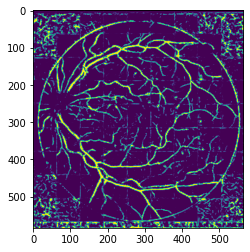

In [39]:
plt.imshow(New_I)

In [41]:
plt.imsave("Example.jpeg",New_I)

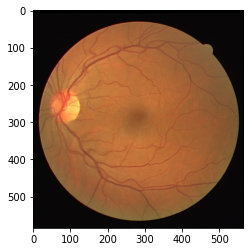

In [40]:
plt.imshow(I)